## Intersubject correlation (ISC) correlates between brains of different participants to capture shared activity

The BOLD signal contains noise. Here, we calculate correlations between subjects to reduce noise and estimate task-relevant signals. Want to find brain regions where the same levels of activity are displayed. Key predictions are that, in the theory encoding region, the ISC should:

1. Be highest for same levels, medium for same games, and lowest for random (shuffled) games
2. Increase over levels of the same game

---

> **Remark.** In this notebook we do an ISC analysis for each voxel time series. In the notebook [ISC_nosmooth](https://github.com/tomov/VGDL-fMRI-Python-Data-Analysis/blob/master/Multivariate_analyses/ISC_nosmooth.ipynb) we correlate between the rows instead (game blocks/levels). A method similar to the analysis performed in (Chen et al., 2016)

---

# ISC analysis smooth betas

- ISC is done *for every voxel* in the brain to the matching voxels in other brains, so it produces a full brain map. (In practice, to simplify the computation and the interpretation it is typical for ISC to compare each individual participant with the average of all other participants)

<img src="http://drive.google.com/uc?export=view&id=11pOdREA7eSauMymUWKCOAXelrYPRuYHF" style="height:250px"/>

- First we load in an anatomical image`.nii` underlay. We use the modules `nibabel` and `nilearn` to work with this kind of data. [more info](https://nipy.org/nibabel/coordinate_systems.html) and [docs](https://nipy.org/nibabel/reference/nibabel.nifti1.html?highlight=nifti1image#nibabel.nifti1.Nifti1Image)
    - after loading in a `.nii` file with `nibabel` the shape is 3D; `(x,y,z)`, these are voxel arrays.
    - e.g. the values (26, 30, 16) are indices into the data array. (26, 30, 16) is therefore a ‘voxel coordinate’. These voxel coordinates are defined in a reference space called voxel space. 
    - **the affine matrix can transform coordinates between references spaces** (affine array tells the position of the image array in a reference space)


> `plot_stat_map`: Plotting a statistical map, like a T-map, a Z-map, or an ICA, with an optional background [more info](https://nilearn.github.io/plotting/index.html#different-plotting-functions)


### Surface plots

- surface plots are diagrams of 3D data
- show a functional relationship between a designated dependent variable (Y), and two independent variables
(X and Z). The plot is a companion plot to the contour plot. [nilearn docs](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_surf_stat_map.html)


# Outline

### 1. ISC with Blocks (`glm1`)

### 2. ISC with Games 

### 3. ISC with Levels (`glm25`)

### 4. ISC with Boxcars (`glm24`)

In [24]:
import h5py
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets, image
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 
import scipy.io as sio

# import own functions
reload(utils)
import utils

#%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

We saved the data as `.npy` files

- `bold_data_[...]`: these files are the processed and reordered betas. This data is in the right shape to perform the ISC analysis with brainiak.

# Load data

In [25]:
# specify local path
path = '/Users/Daphne/data/'

# parameters
num_subjects = 8

# # load all bold data
games_betas = np.load(path+'bold_data_games.npy')
blocks_betas = np.load(path+'bold_data_blocks.npy')
levels_betas = np.load(path+'bold_data_levels.npy')
# boxcar_betas = np.load(path+'bold_data_boxcar.npy')

# load mask and get voxel coordinates
mask_arr = np.load(path+'mask_arr.npy') # all masks are the same
mask_mat = mask_arr[0] # so we can pick any one from the array
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all

In [26]:
coords_mat 

array([[ 0,  0,  0, ..., 77, 77, 77],
       [26, 26, 27, ..., 52, 52, 52],
       [39, 40, 36, ..., 34, 35, 44]])

In [27]:
coords_nii

(array([ 2,  3,  3, ..., 74, 74, 74]),
 array([43, 42, 43, ..., 45, 47, 51]),
 array([32, 31, 32, ..., 31, 26, 26]))

Correct the mask so that it lines up with the `mask_nii`

In [28]:
for r in coords_mat:
    print(r)
# swap row 0 and 2

[ 0  0  0 ... 77 77 77]
[26 26 27 ... 52 52 52]
[39 40 36 ... 34 35 44]


In [29]:
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows

In [30]:
for r in coords_mat:
    print(r)
# swap row 0 and 2

[39 40 36 ... 34 35 44]
[26 26 27 ... 52 52 52]
[ 0  0  0 ... 77 77 77]


## make a new mask_mat with these coordinates

In [31]:
mask_mat_corrected = np.zeros(mask_mat.shape) # make a zeros volume
num_voxels = coords_mat[0] # number of voxels, these are all the coordinates == len(rows)

for col in range(len(num_voxels)):
    
    # take the x,y,z values
    x = coords_mat[:, col][0]
    y = coords_mat[:, col][1]
    z = coords_mat[:, col][2]
    
    mask_mat_corrected = 1 # put a 1 in this spot 

## Load nifti data

In [32]:
'''load brain templates'''

# mask_nii is the functional mask, this selects the brain voxels
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 

# we get the brain mask (boolean array) with the .dataobj method
brain_mask = np.array(mask_nii.dataobj)

# Get the list of nonzero voxel coordinates from the nii mask
coords_nii = np.where(brain_mask)

# this where we plot our mask ON (sometimes called brain_nii) - the anatomical/structural image
mean_nii = nib.load(os.path.join(path, 'mean.nii')) 

# nosmooth betas mask, has less voxels than mask_nii
nosmooth_mask_nii = nib.load(os.path.join(path, 'mask_nosmooth.nii'))

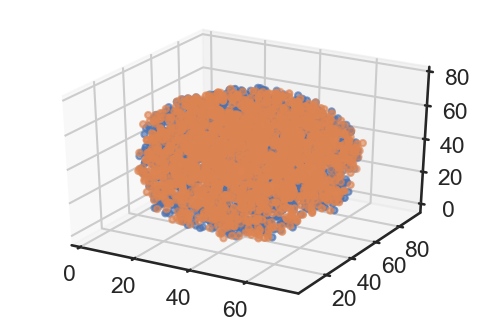

In [33]:
fig = plt.figure(dpi=100)
ax = plt.axes(projection="3d")
ax.scatter3D(coords_nii[0][::100], coords_nii[1][::100], coords_nii[2][::100]);# plot only every k=100 indices (faster)
ax.scatter3D(coords_mat[0][::100], coords_mat[1][::100], coords_mat[2][::100]);# plot only every k indices (faster)

In [34]:
mask_nii.shape

(79, 95, 79)

In [35]:
nosmooth_mask_nii.shape

(79, 95, 79)

In [36]:
mean_nii.shape

(157, 189, 156)

## Check data shapes

In [37]:
games_betas.shape

(6, 220075, 8)

In [38]:
blocks_betas.shape

(18, 220075, 8)

In [39]:
levels_betas.shape

(54, 220075, 8)

> `plot_stat_map(): `Plotting a statistical map, like a T-map, a Z-map, or an ICA, with an optional background [documentation](http://nilearn.github.io/plotting/index.html)

---



# Load in ISC data to visualise on brain

In [40]:
iscs_p_games = np.load(path+'iscs_p_games.npy')
iscs_r_games = np.load(path+'iscs_r_games.npy')
col_iscs_games = np.load(path+'collapsed_iscs_games.npy')
sig_r_games = np.load(path+'significant_r_games.npy')

iscs_p_blocks = np.load(path+'iscs_p_blocks.npy')
iscs_r_blocks = np.load(path+'iscs_r_blocks.npy')
col_iscs_blocks = np.load(path+'collapsed_iscs_blocks.npy')
sig_r_blocks = np.load(path+'significant_r_blocks.npy')

iscs_p_levels = np.load(path+'iscs_p_levels.npy')
iscs_r_levels = np.load(path+'iscs_r_levels.npy')
col_iscs_levels = np.load(path+'collapsed_iscs_levels.npy')

sig_r_levels = np.load(path+'significant_r_levels.npy')

In [91]:
sig_r_games

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.89217712, 0.89344586,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [86]:
# collapsing the significant onces
col_iscs_sig_games = utils.compute_avg_iscs(sig_r_games)
col_iscs_sig_blocks = utils.compute_avg_iscs(sig_r_blocks)
col_iscs_sig_levels = utils.compute_avg_iscs(sig_r_levels)

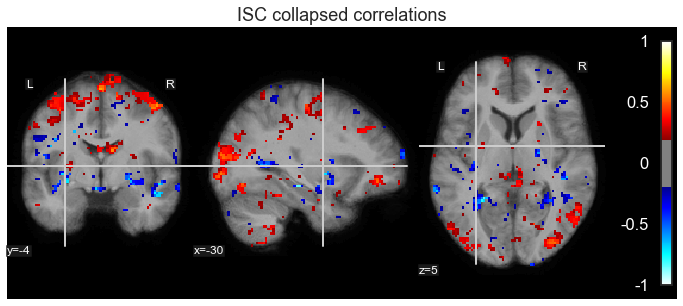

In [87]:
utils.plot_statmap_collapsed(coords=coords_mat, 
                             collapsed_isc_corrs=col_iscs_sig_games, 
                             brain_nii=mean_nii, 
                             mask_nii=mask_nii, 
                             threshold=0.2
                            )

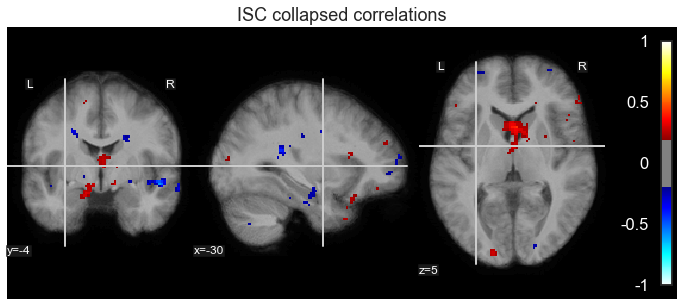

In [88]:
utils.plot_statmap_collapsed(coords=coords_mat, 
                             collapsed_isc_corrs=col_iscs_sig_blocks, 
                             brain_nii=mean_nii, 
                             mask_nii=mask_nii, 
                             threshold=0.2
                            )

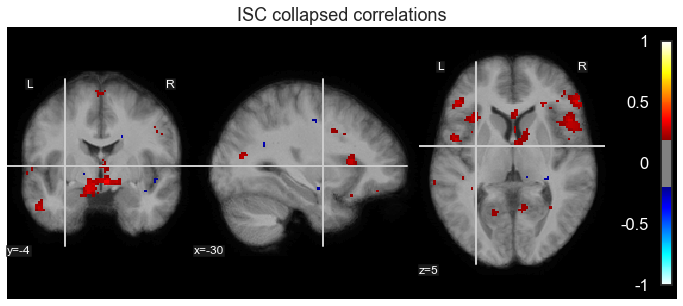

In [89]:
utils.plot_statmap_collapsed(coords=coords_mat, 
                             collapsed_isc_corrs=col_iscs_sig_levels, 
                             brain_nii=mean_nii, 
                             mask_nii=mask_nii, 
                             threshold=0.2
                            )

In [82]:
sig_r_games.shape

(8, 220075)

In [42]:
col_iscs_games.shape

(220075,)

In [63]:
sig_r_games.shape

(8, 220075)

# Leaving this here for potential debugging (now in `utils.py`)

In [49]:
# 1) create a volume from mask_nii
isc_vol = np.zeros(mask_nii.shape) 

In [50]:
# 2) Map the ISC data 
isc_vol[tuple(coords_mat)] = col_iscs_games

In [51]:
np.unique(isc_vol) # so this worked out..

array([-0.981997  , -0.98157827, -0.96740782, ...,  0.75547605,
        0.7567144 ,  0.76332084])

In [52]:
# 3) make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, mask_nii.affine, mask_nii.header)

In [53]:
# something is wrong with the voxel order in the correlations vs the mask

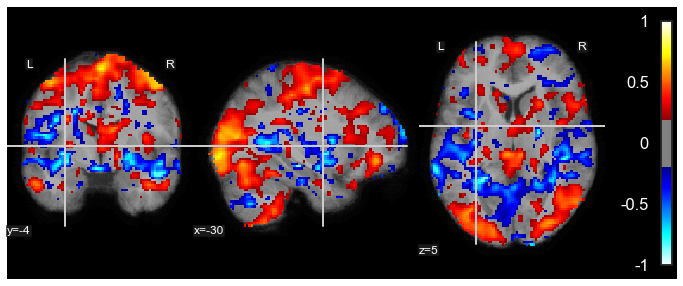

In [54]:
# plot the data as statmap
f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    stat_map_img=isc_nifti,
    bg_img=mean_nii,
    threshold=0.2, 
    axes=ax,
    cut_coords=[-30, -4, 5],
    vmax=1
);

# Mapping iscs on brain

> `.dataobj: ` Object containg image data. It should be some object that retuns an array from np.asanyarray. It should have a shape attribute or property


- `mask.nii` contains the whole brain mask
- We overlay the whole brain mask on top of the anatomical image, `mean.nii`.

We perform the following steps:

1. Create a volume from `mask.nii` (`isc_vol`) (or anything with the same shape really)
2. Use the (corrected!) coordinates to map the correlations in voxel space (`coords_mat`)
3. Create a nifti image from this `nib.Nifti1Image(...)` with the affine from `mask_nii`
4. Plot the statistical map

# 1. Games

## 1.1 ISC per subject (all r values)

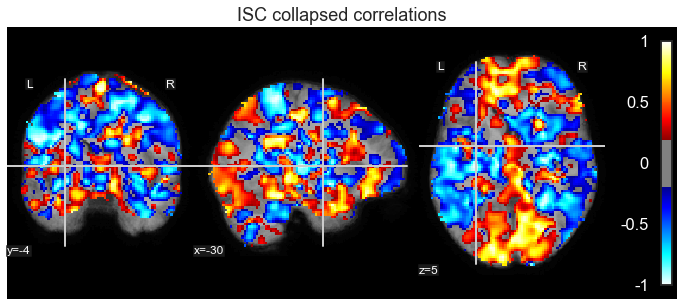

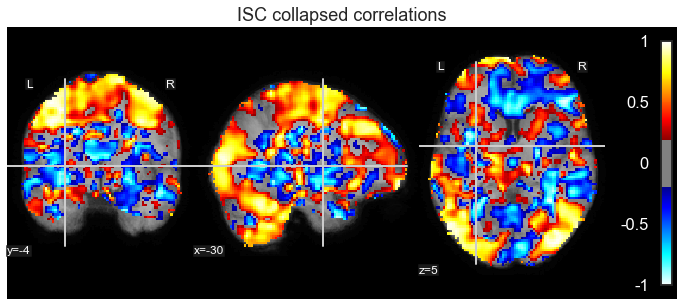

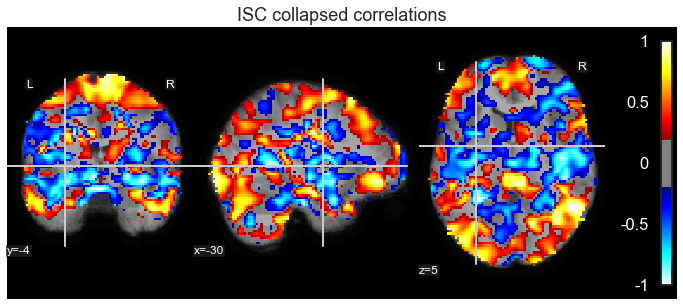

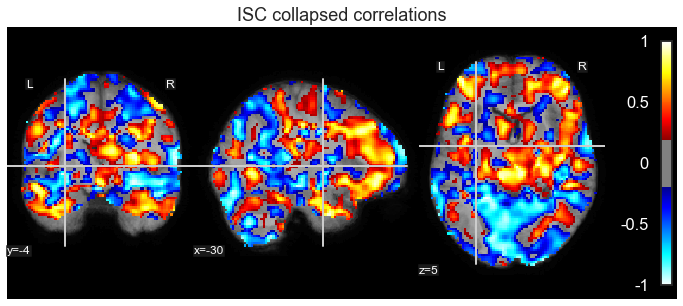

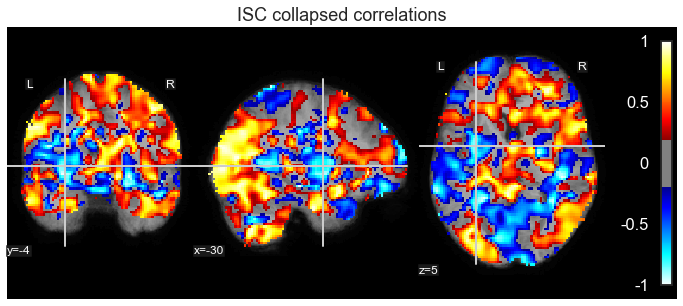

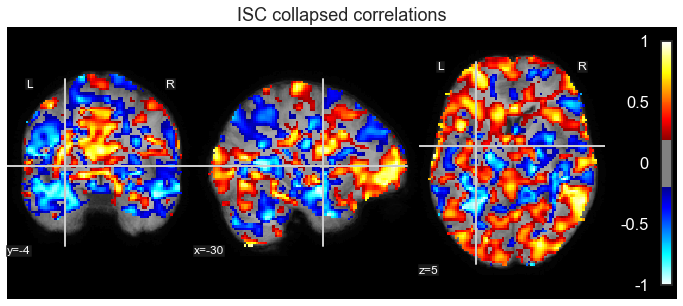

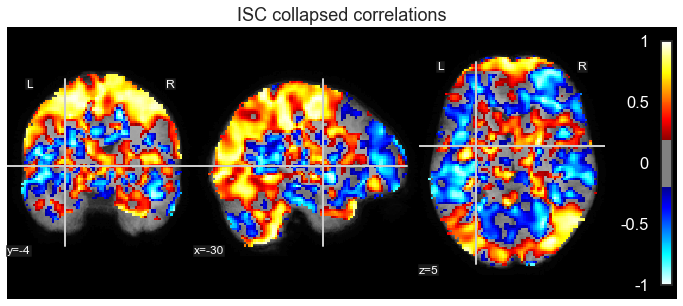

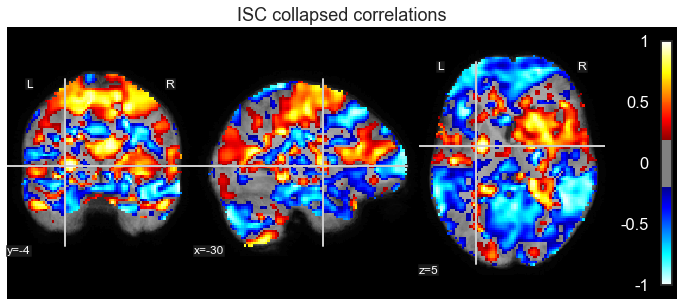

In [62]:
for i in range(num_subjects):

    utils.plot_correlations_onesub(sub=i, 
                        coords=coords_mat,
                        isc_maps=iscs_r_games, 
                        brain_nii=mean_nii, 
                        mask_nii=mask_nii,
                        threshold=0.2
                       )

## 1.2 Collapsed correlations

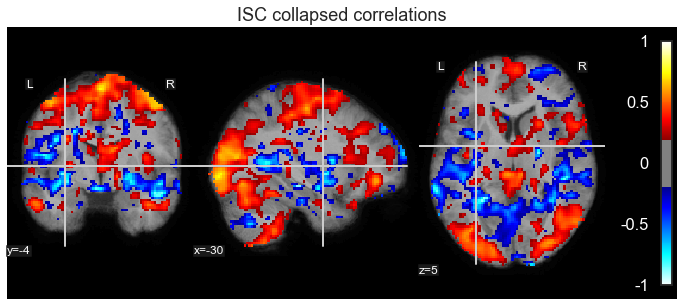

In [55]:
utils.plot_statmap_collapsed(coords=coords_mat, 
                             collapsed_isc_corrs=col_iscs_games, 
                             brain_nii=mean_nii, 
                             mask_nii=mask_nii, 
                             threshold=0.2
                            )

## 1.3 Statistical map with significant r values only ($p<0.05$)

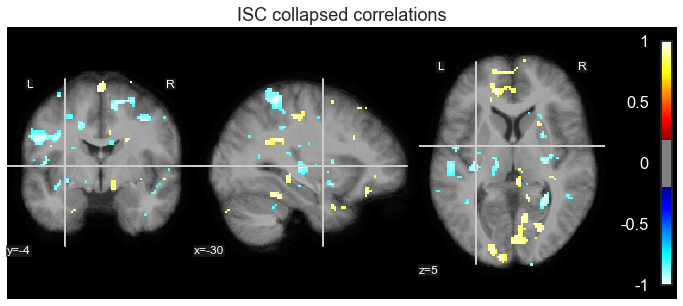

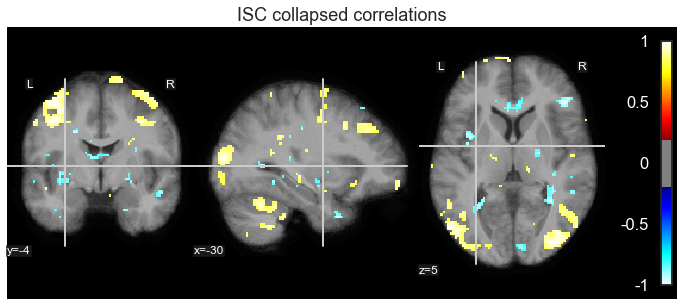

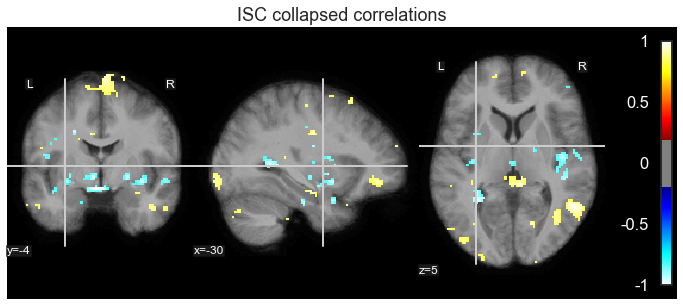

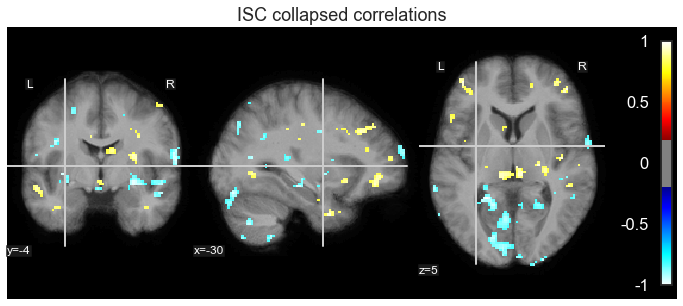

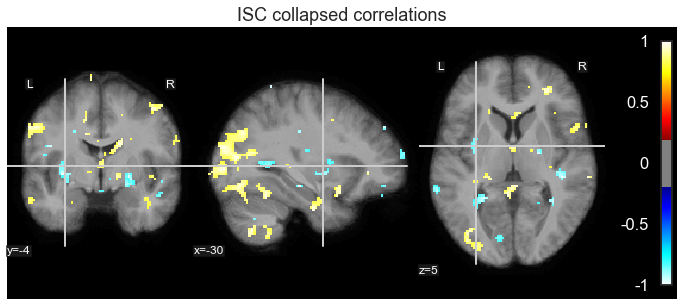

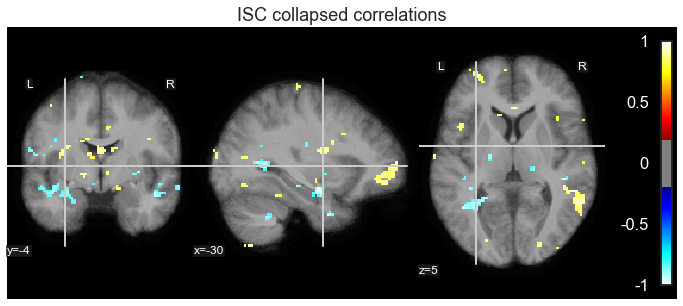

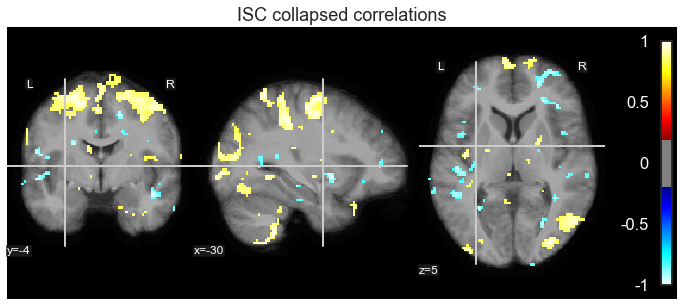

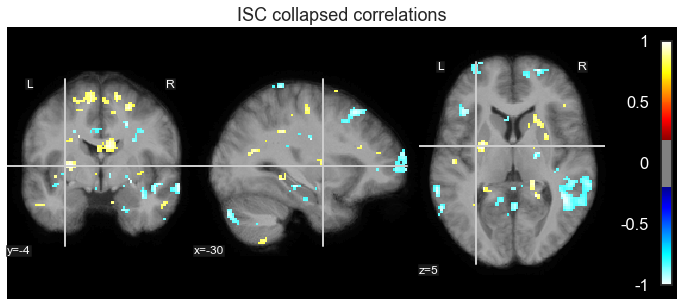

In [64]:
for i in range(num_subjects):

    utils.plot_correlations_onesub(sub=i, 
                        coords=coords_mat,
                        isc_maps=sig_r_games, 
                        brain_nii=mean_nii, 
                        mask_nii=mask_nii,
                        threshold=0.2
                       )

## 1.4 Surface plot collapsed correlations

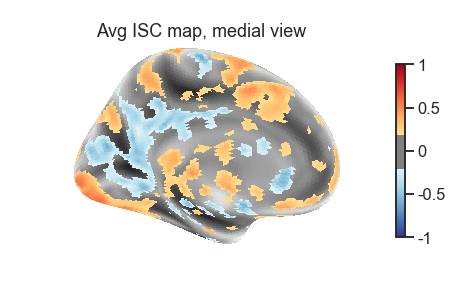

In [67]:
utils.surface_plot_collapsed(coords=coords_mat, 
                             brain_nii=mean_nii,
                             mask_nii=mask_nii,
                             collapsed_isc_corrs=col_iscs_games, 
                             view='medial', 
                             threshold=0.2
                            )

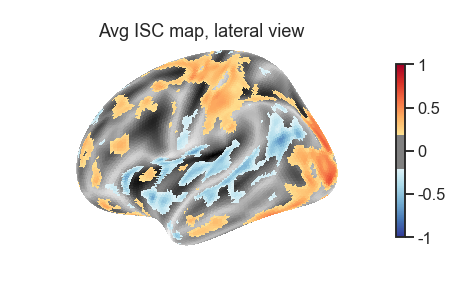

In [68]:
utils.surface_plot_collapsed(coords=coords_mat, 
                             brain_nii=mean_nii,
                             mask_nii=mask_nii,
                             collapsed_isc_corrs=col_iscs_games, 
                             view='lateral', 
                             threshold=0.2
                            )

# 2. Blocks

## 2.1 ISC per subject (all r values)

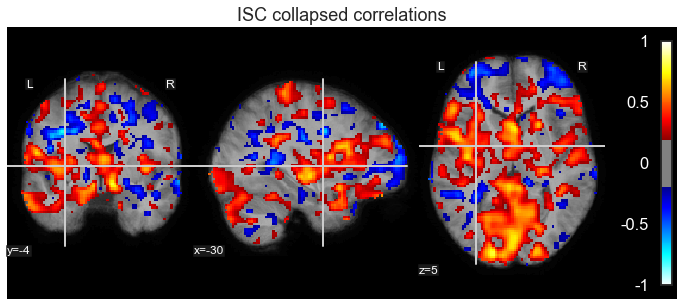

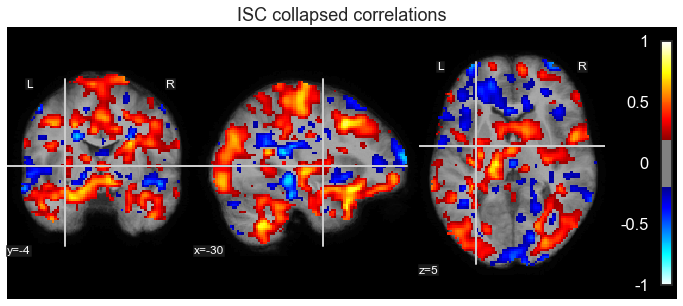

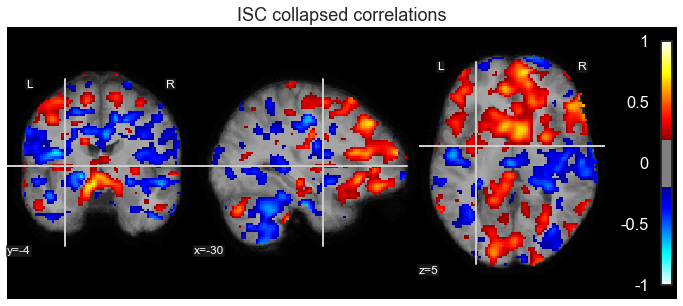

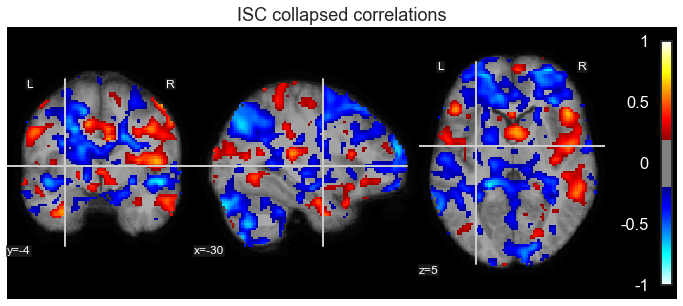

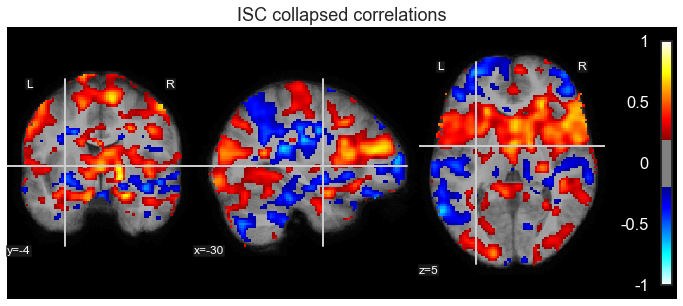

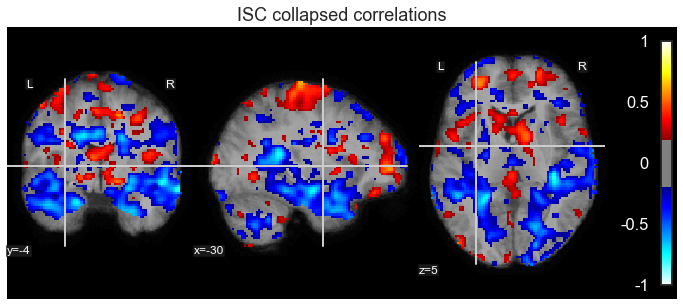

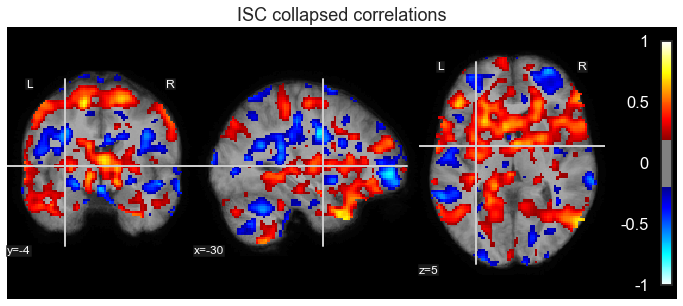

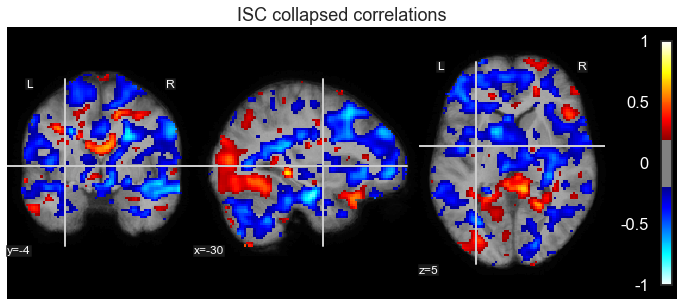

In [69]:
for i in range(num_subjects):

    utils.plot_correlations_onesub(sub=i, 
                        coords=coords_mat,
                        isc_maps=iscs_r_blocks, 
                        brain_nii=mean_nii, 
                        mask_nii=mask_nii,
                        threshold=0.2
                       )

## 2.2 Collapsed correlations (all r values)

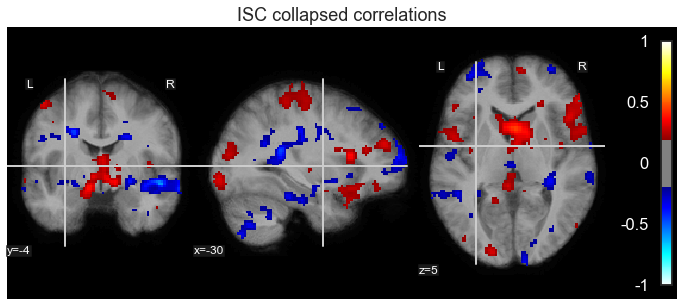

In [70]:
utils.plot_statmap_collapsed(coords=coords_mat, 
                             collapsed_isc_corrs=col_iscs_blocks, 
                             brain_nii=mean_nii, 
                             mask_nii=mask_nii, 
                             threshold=0.2
                            )

## 2.3 Statistical map with significant r values only ($p<0.05$)

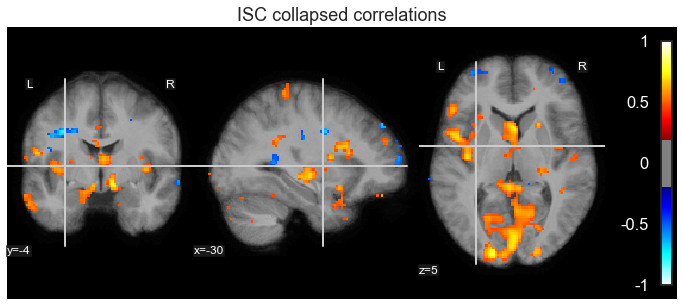

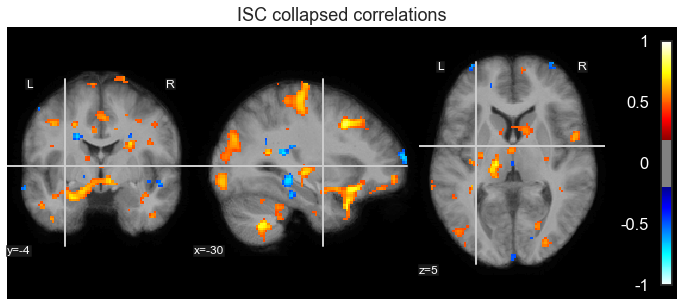

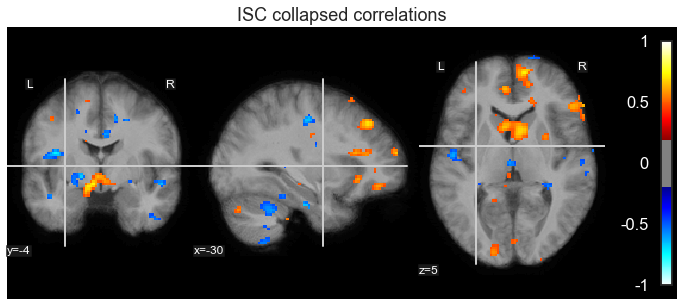

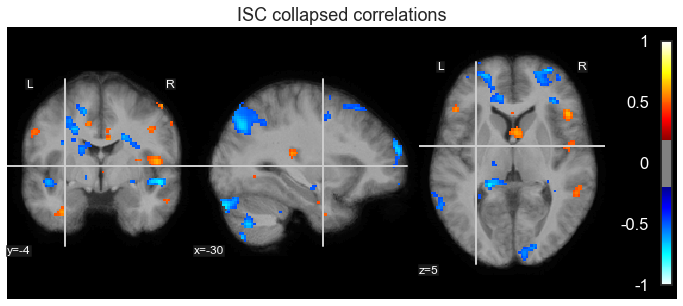

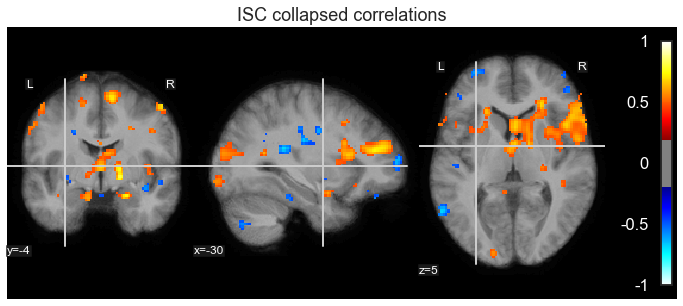

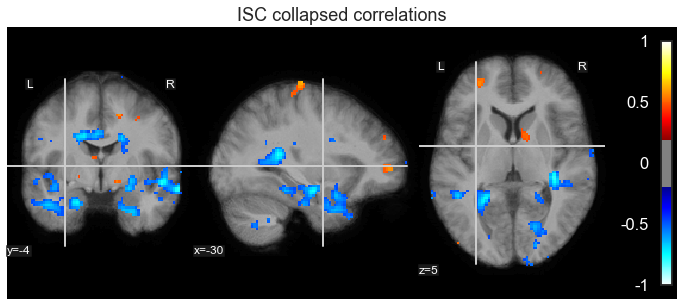

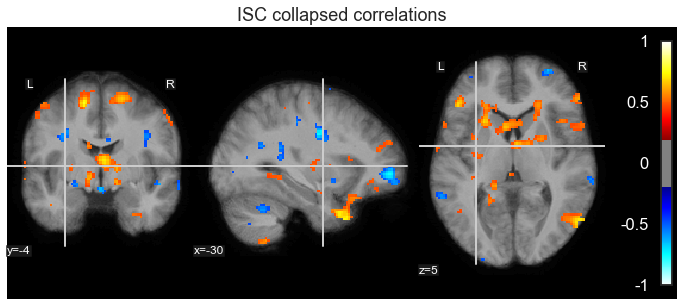

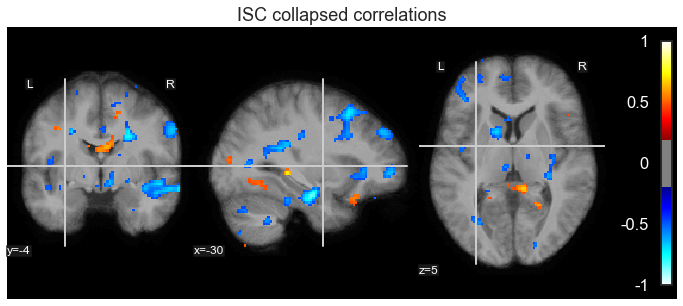

In [71]:
for i in range(num_subjects):

    utils.plot_correlations_onesub(sub=i, 
                        coords=coords_mat,
                        isc_maps=sig_r_blocks, 
                        brain_nii=mean_nii, 
                        mask_nii=mask_nii,
                        threshold=0.2
                       )

## 2.4 Surface plots 

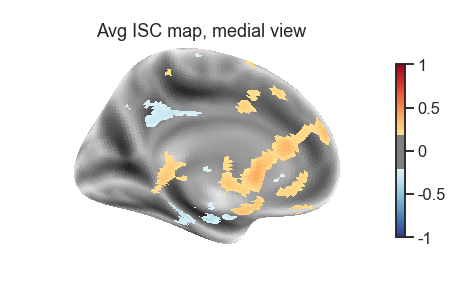

In [72]:
utils.surface_plot_collapsed(coords=coords_mat, 
                             brain_nii=mean_nii,
                             mask_nii=mask_nii,
                             collapsed_isc_corrs=col_iscs_blocks, 
                             view='medial', 
                             threshold=0.2
                            )

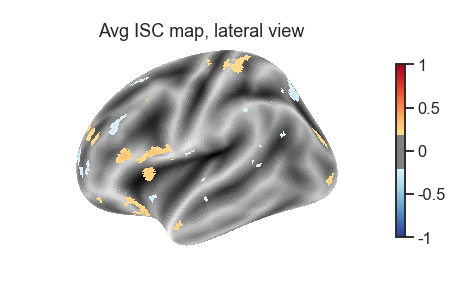

In [79]:
utils.surface_plot_collapsed(coords=coords_mat, 
                             brain_nii=mean_nii,
                             mask_nii=mask_nii,
                             collapsed_isc_corrs=col_iscs_blocks, 
                             view='lateral', 
                             threshold=0.2
                            )

[other plotting options](http://nilearn.github.io/auto_examples/01_plotting/plot_3d_map_to_surface_projection.html#sphx-glr-auto-examples-01-plotting-plot-3d-map-to-surface-projection-py)

# 3. Levels

## 3.1 ISC per subject (all r values)

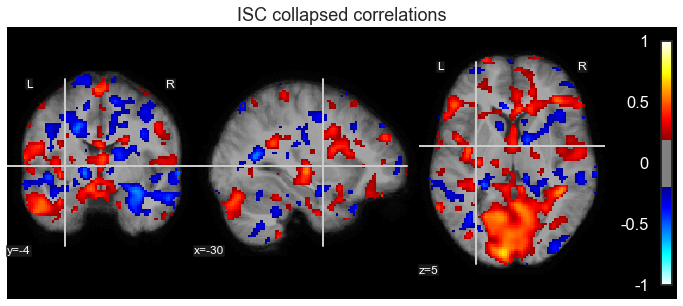

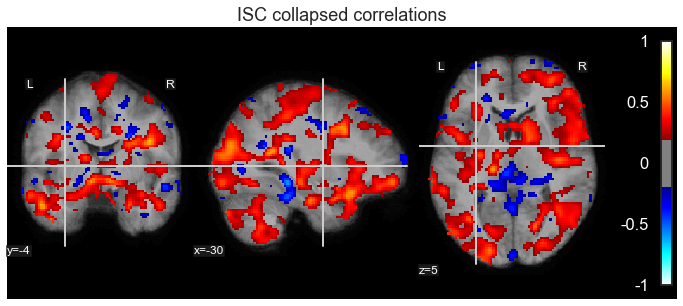

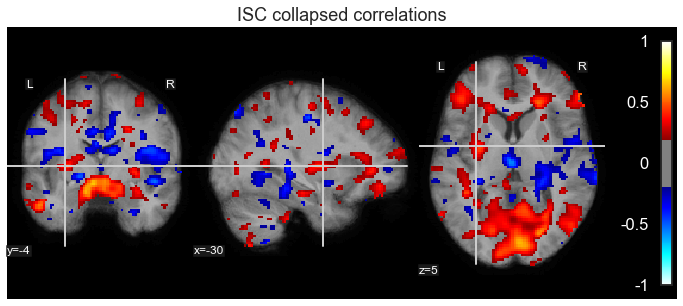

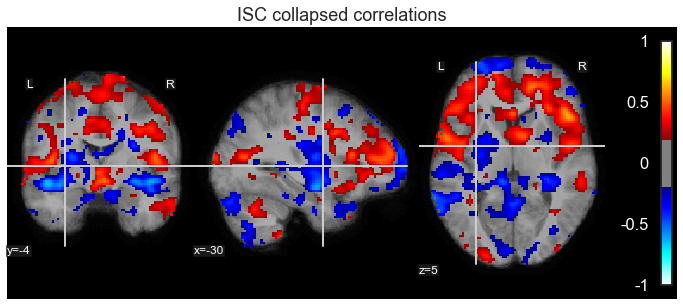

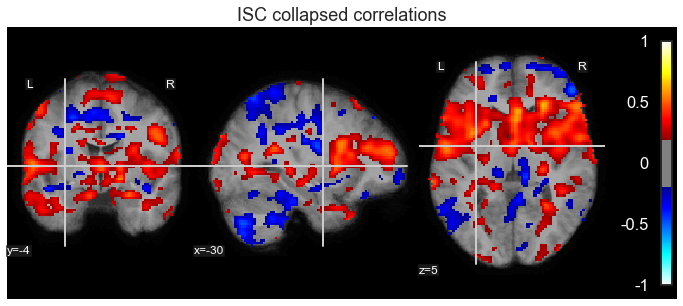

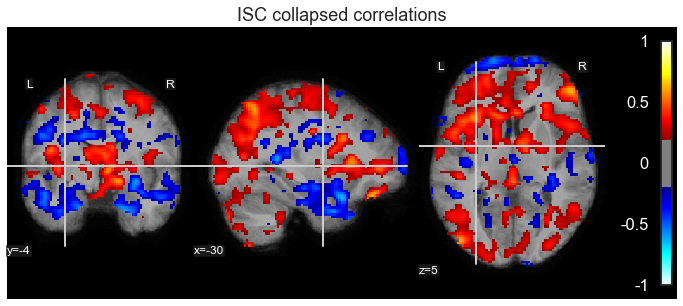

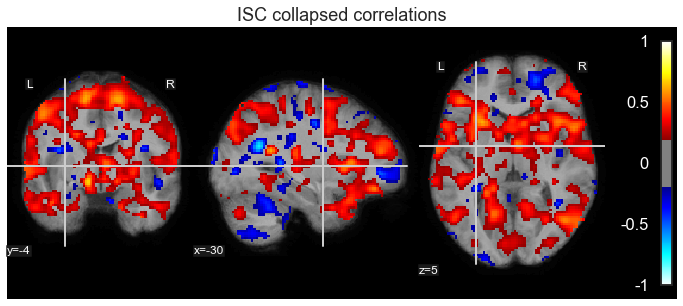

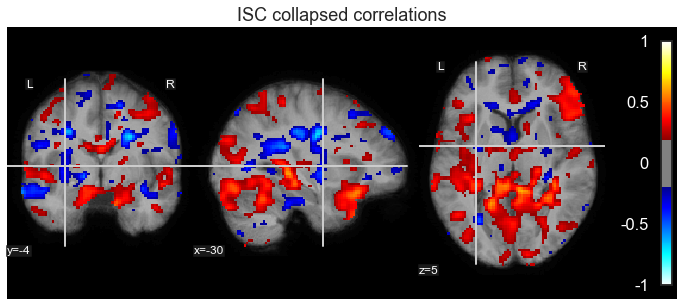

In [74]:
for i in range(num_subjects):

    utils.plot_correlations_onesub(sub=i, 
                        coords=coords_mat,
                        isc_maps=iscs_r_levels, 
                        brain_nii=mean_nii, 
                        mask_nii=mask_nii,
                        threshold=0.2
                       )

## 3.2 Collapsed correlations (all r values)

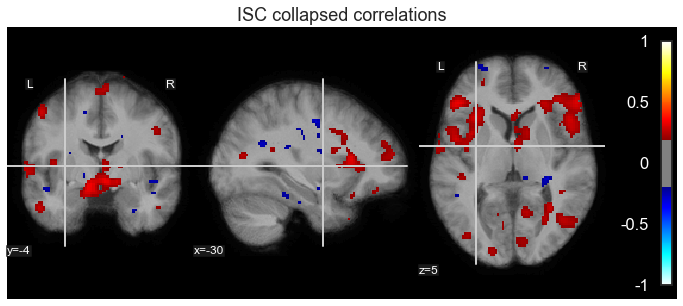

In [75]:
utils.plot_statmap_collapsed(coords=coords_mat, 
                             collapsed_isc_corrs=col_iscs_levels, 
                             brain_nii=mean_nii, 
                             mask_nii=mask_nii, 
                             threshold=0.2
                            )

## 3.3 Statistical map with significant r values only ($p<0.05$)

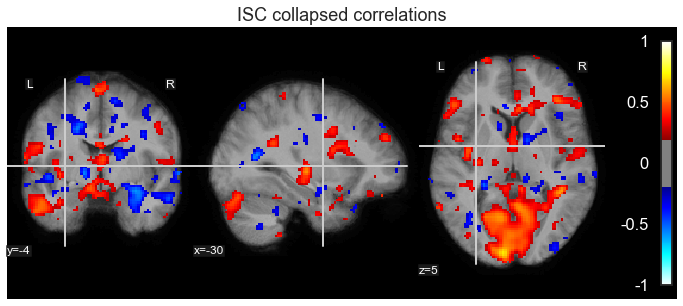

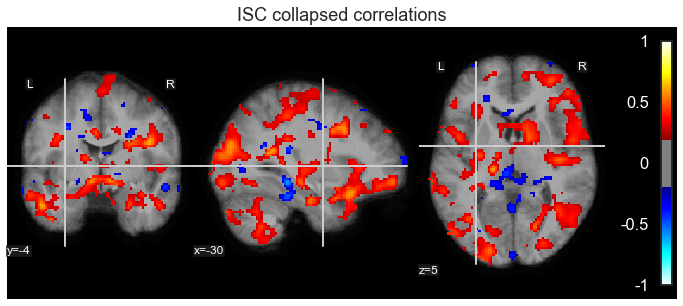

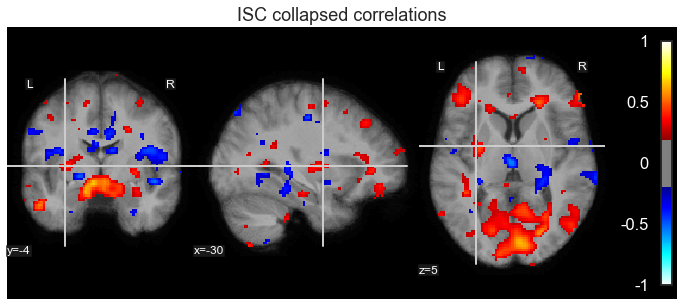

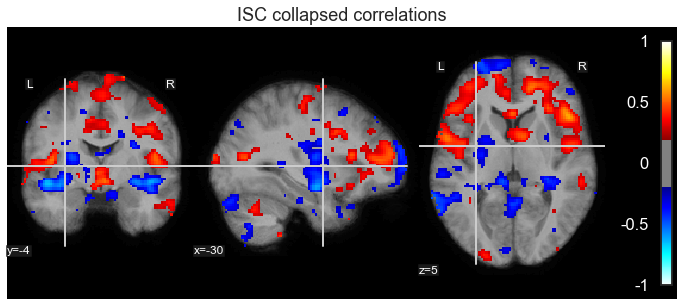

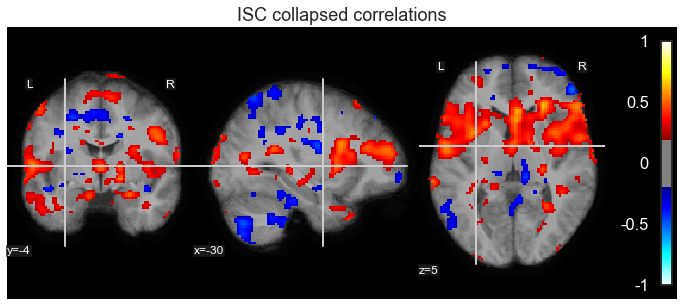

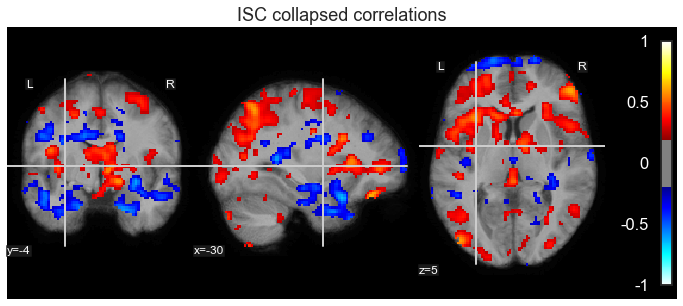

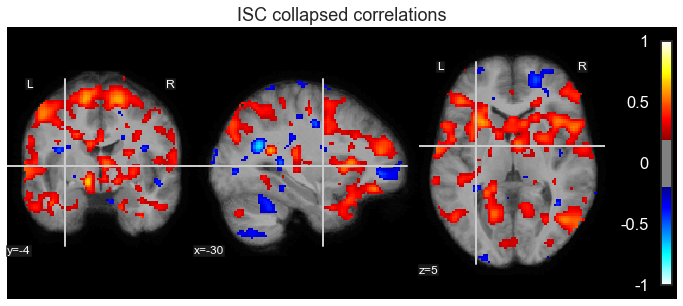

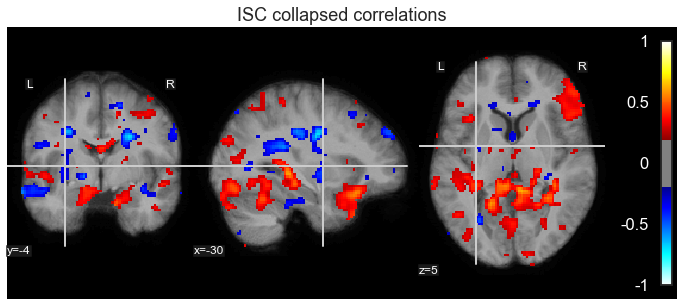

In [76]:
for i in range(num_subjects):

    utils.plot_correlations_onesub(sub=i, 
                        coords=coords_mat,
                        isc_maps=sig_r_levels, 
                        brain_nii=mean_nii, 
                        mask_nii=mask_nii,
                        threshold=0.2
                       )

## 3.4 Surface plots 

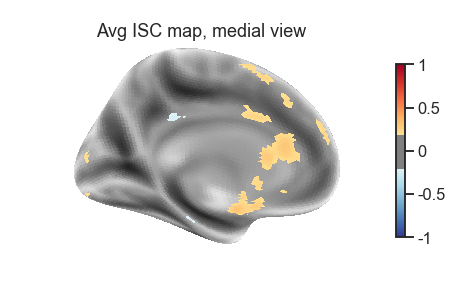

In [77]:
utils.surface_plot_collapsed(coords=coords_mat, 
                             brain_nii=mean_nii,
                             mask_nii=mask_nii,
                             collapsed_isc_corrs=col_iscs_levels, 
                             view='medial', 
                             threshold=0.2
                            )

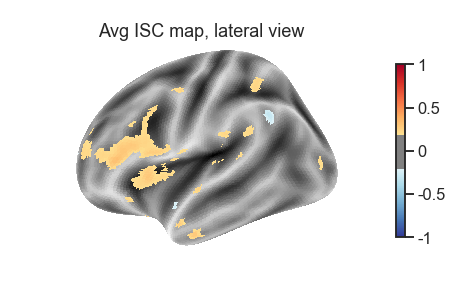

In [78]:
utils.surface_plot_collapsed(coords=coords_mat, 
                             brain_nii=mean_nii,
                             mask_nii=mask_nii,
                             collapsed_isc_corrs=col_iscs_levels, 
                             view='lateral', 
                             threshold=0.2
                            )

# 4. Boxcars

## Links

[neuroimaging data representation](http://nilearn.github.io/manipulating_images/input_output.html)

[plotting brain images options with nilearn](http://nilearn.github.io/plotting/index.html#id7)


## Save stuff


```Python
# as npy file
path = '/Users/name/...'
arr = ...

np.save(path+'file_name', arr)
```


```Python
# as matlab file
sio.savemat('file_name.mat', {'mydata': arr})
```

<font color=red>TODO: Check matlab code momchil sent me. </font>